## Telemetry

In [4]:
import os
import glob
import datetime
import re
from typing import Union, List, Tuple

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm


In [52]:
def csv_to_parquet(file_path: str,
                   output_directory: str):
    """Convert CSV files to Parquet file format."""

    # create output file name
    output_parquet_file = os.path.join(output_directory, f"{os.path.splitext(os.path.basename(file_path))[0]}.parquet")
    
    # construct query to convert to parquet files
    sql = f"""
    COPY(
        SELECT
            *
        FROM 
            '{file_path}'
        ) TO '{output_parquet_file}' (FORMAT PARQUET);
    """
    
    # execute conversion
    duckdb.query(sql)
    
    return output_parquet_file


def read_tagging_file(tagging_file: str) -> pd.DataFrame:
    """Read in raw excel tagging file to data frame and add field for PST date time fields."""
    
    # read in tagging data
    df = pd.read_excel(tagging_file)

    # rename fields
    df.rename(columns={"rel_datetime": "tag_release_date"}, inplace=True)

    # adjust date times in tagging file to PST
    df["tag_activation_date_pst"] = pd.to_datetime(df["tag_activation_date"]) - pd.Timedelta(hours=1)
    df["tag_release_date_pst"] = pd.to_datetime(df["tag_release_date"]) - pd.Timedelta(hours=1)
    
    return df.sort_values(by="fish_id").reset_index(drop=True)


def read_beacon_file(beacon_file: str) -> pd.DataFrame:
    """Read in raw beacon file to data frame."""
    
    pass


def generate_directory_list(target_directory: str,
                            ignore_dirs: Tuple[str] = (".DS_Store", "pre_study", "zips", ".zip")) -> list:
    """Generate a clearn directory list."""
    
    return [os.path.join(target_directory, i) for i in os.listdir(target_directory) if i not in ignore_dirs]


def add_trailing_zeros(x: str, 
                       length: int):
    """Add trailing zeros to a string."""
    
    return(x + f"{'0' * (length - len(x))}")


def add_leading_zeros(x: str, 
                    length: int):
    """Add leading zeros to a string."""
    
    return(f"{'0' * (length - len(x))}" + x)


def validate_file_to_directory_match(file_list: list):
    """Validate file names to their parent directory to ensure that no errors have occurred."""

    valid_list = []
    
    for i in file_list:

        # get the source directory name of the download
        source_directory = os.path.basename(os.path.dirname(i))

        # extact the file parts to match to source directory
        target_file_parts = os.path.splitext(os.path.basename(i))
        target_file_base = target_file_parts[0].split("_")[-1]
        target_file_extension = target_file_parts[1]

        if source_directory != target_file_base:
            print(f"File '{i}' does not match the parent directory name.")
            print("Removing from inputs.  Please review.")

        else:
            valid_list.append(i)

    return valid_list


def generate_orion_import_file_list(orion_dir: str):
    """Generate a list of orion files to import after validation."""

    # generate full path lists of text and hex files in the orion directory
    text_files = glob.glob(os.path.join(orion_dir, "**/*.txt"))
    hex_files = glob.glob(os.path.join(orion_dir, "**/*.hex"))

    # validate file name to directory name match
    text_files = validate_file_to_directory_match(text_files)
    hex_files = validate_file_to_directory_match(hex_files)

    # validate to ensure a hex / text pair
    text_file_base_list = [os.path.splitext(os.path.basename(i))[0] for i in text_files]
    hex_file_base_list = [os.path.splitext(os.path.basename(i))[0] for i in hex_files]

    # files in text list not in hex list
    no_match_text_files = set(text_file_base_list) - set(hex_file_base_list)

    # files in hex list not in text list
    no_match_hex_files = set(hex_file_base_list) - set(text_file_base_list)

    if len(no_match_text_files) > 0:
        print(f"There are not hex file matches for the following text files: {no_match_text_files}")

    if len(no_match_hex_files) > 0:
        print(f"There are not text file matches for the following hex files: {no_match_hex_files}")

    # hex file size should be smaller than the text file or something may be wrong
    text_file_sizes = [os.stat(i).st_size for i in text_files]
    hex_file_sizes = [os.stat(i).st_size for i in hex_files]

    for index, i in enumerate(text_files):
        
        text_file_size = os.stat(i).st_size
        hex_file_size = os.stat(f"{os.path.splitext(i)[0]}.hex").st_size

        if hex_file_size >= text_file_size:
            print(f"WARNING:  Text file '{i}' is smaller than or equal to the hex file size (bytes).")
            print(f"Text file size: {text_file_size}, Hex file size: {hex_file_size}, Difference (hex - text): {hex_file_size - text_file_size}")
            print(f"Removing files from import.  Please review.")

            # remove files with incorrect sizes
            text_files.remove(text_files[index])
            
    return text_files


def whitespace_to_csv(input_file:str, 
                      output_dir:str) -> str:
    """Generate new output files with whitespace converted to CSV."""
    
    # extract basename from input file
    basename = os.path.splitext(os.path.basename(input_file))[0]
    
    # construct output file name
    output_file = os.path.join(output_dir, f"{basename}.csv")
    
    # open file to write
    with open(output_file, "w") as out:
        
        # read input file as string
        with open(input_file) as get:
            content = get.read()
            
            # write content replacing any whitespace with commas but keeping new lines or carriage returns
            out.write(re.sub("[^\S^\r\n]+", ",", content))
            
    return output_file


def orion_raw_to_parquet(input_file: str,
                         output_directory: str,
                         target_frequency_list: list,
                         target_code_list: list) -> str:
    """Create a parquet file for each formatted CSV."""
    
    # extract file name from input file
    file_name = f"0_ORION_{os.path.splitext(os.path.basename(input_file))[0]}"
    
    # create output file name
    output_parquet_file = os.path.join(output_directory, f"{file_name}.parquet")


    sql = f"""
    COPY(
        SELECT
            concat(
                CASE
                    WHEN length(Freq::VARCHAR) = 4
                    THEN Freq::VARCHAR || '000'
                    WHEN length(Freq::VARCHAR) = 5
                    THEN Freq::VARCHAR || '00'        
                    WHEN length(Freq::VARCHAR) = 6
                    THEN Freq::VARCHAR || '0' 
                    ELSE Freq::VARCHAR 
                END
                ,'.'
                ,CASE
                    WHEN length(Code::VARCHAR) = 1
                    THEN '00' || Code::VARCHAR
                    WHEN length(Code::VARCHAR) = 2
                    THEN '0' || Code::VARCHAR  
                    ELSE Code::VARCHAR
                END
            ) AS fish_id
            ,(Date + Time) AS date_time
            ,Site AS receiver_id
            ,Power AS signal_power
            ,'{file_name}' AS file_nm
        FROM
            read_csv_auto('{input_file}')
        WHERE
            Freq IS NOT NULL
            AND Code IS NOT NULL
            AND Date IS NOT NULL
            AND Time IS NOT NULL
            AND Site IS NOT NULL
            AND Power IS NOT NULL
            AND Type IS NOT NULL 
            AND Type = 'LOTEK'
            AND Freq IN {tuple(target_frequency_list)}
            AND Code IN {tuple(target_code_list)}
        ) TO '{output_parquet_file}' (FORMAT PARQUET);
    """
    
    # execute query
    duckdb.query(sql)
    
    return output_parquet_file


def generate_orion_parquet_files(orion_dir: str,
                                 target_frequency_list: List[float],
                                 target_code_list: List[int],
                                 output_directory: str) -> List[str]:
    """Generate ORION parquet files for query."""
    
    # generate the full file list to process
    file_list = tqdm(generate_orion_import_file_list(orion_dir))

    # process files
    processed_files = []
    for i in file_list:

        # convert all whitespace in Orion text files to commas
        raw_csv_file = whitespace_to_csv(i, orion_dir)

        # convert CSV file to parquet format
        parquet_file = orion_raw_to_parquet(input_file=raw_csv_file,
                                            output_directory=output_directory,
                                            target_frequency_list=target_frequency_list,
                                            target_code_list=target_code_list)
        # add processed file to output list
        processed_files.append(parquet_file)
    
    return processed_files


def mitas_raw_to_parquet(input_file: str,
                         output_directory: str,
                         target_frequency_list: List[float],
                         target_code_list: List[int]):
    """Ingest and format an input MITAS file."""
        
    # extract file name from input file
    file_name = f"1_MITAS_{os.path.splitext(os.path.basename(input_file))[0]}"
    
    # create output file name
    output_parquet_file = os.path.join(output_directory, f"{file_name}.parquet")
    
    # Erin added datetime conversion of UTC-04:00 datetime to UTC-07:00 datetime
    sql = f"""
    COPY(
        SELECT
            concat(
                CASE
                    WHEN length(frequency::VARCHAR) = 4
                    THEN frequency::VARCHAR || '000'
                    WHEN length(frequency::VARCHAR) = 5
                    THEN frequency::VARCHAR || '00'        
                    WHEN length(frequency::VARCHAR) = 6
                    THEN frequency::VARCHAR || '0' 
                    ELSE frequency::VARCHAR 
                END
                ,'.'
                ,CASE
                    WHEN length(codeNumber::VARCHAR) = 1
                    THEN '00' || codeNumber::VARCHAR
                    WHEN length(codeNumber::VARCHAR) = 2
                    THEN '0' || codeNumber::VARCHAR  
                    ELSE codeNumber::VARCHAR
                END
            ) AS fish_id
            ,"decodeTimeUTC-04:00" - interval '3 hours' AS date_time
            ,ReceiverId AS receiver_id
            ,power::INT AS signal_power
            ,'{file_name}' AS file_nm
        FROM
            '{input_file}'
        WHERE
            frequency IS NOT NULL
            AND codeNumber IS NOT NULL
            AND "decodeTimeUTC-04:00" IS NOT NULL
            AND ReceiverId IS NOT NULL
            AND power IS NOT NULL
            AND frequency IN {tuple(target_frequency_list)}
            AND codeNumber IN {tuple(target_code_list)}
        ) TO '{output_parquet_file}' (FORMAT PARQUET);
    """
    
    # fire query
    duckdb.query(sql)
    
    return output_parquet_file


def generate_mitas_parquet_files(mitas_dir: str,
                                 target_frequency_list: List[float],
                                 target_code_list: List[int],
                                 output_directory: str) -> List[str]:
    """Generate MITAS parquet files for use in query."""
    
    # get a list of mitas CSV files
    mitas_csv_files = glob.glob(os.path.join(mitas_dir, "*.csv"))

    processed_files = []
    for i in tqdm(mitas_csv_files):

        # convert each file to a parquet file
        output_file = mitas_raw_to_parquet(input_file=i, 
                                           output_directory=output_directory,
                                           target_frequency_list=target_frequency_list,
                                           target_code_list=target_code_list)
        
        # add processed file to output list
        processed_files.append(output_file)
        
    return processed_files


def filter_tagged_fish(df, tagging_df):
    """Only keep fish in tagging file."""
    
    n_records = df.shape[0]

    # only keep fish in tagging file
    df = df.loc[df["fish_id"].isin(tagging_df["fish_id"].unique())]

    n_dropped = n_records - df.shape[0]

    print(f"Dropped {n_dropped} records for fish not in tagging file.")
    
    return df 


def filter_release_time(df, tagging_df):
    """Only keep records greater than or equal to release time."""
    
    n_records = df.shape[0]

    # get a lookup dictionary of release date times from each fish
    fish_release_time_dict = tagging_df.set_index("fish_id")["tag_release_date_pst"].to_dict()

    # add field for release time to bound study start
    df["tag_release_date_pst"] = df["fish_id"].map(fish_release_time_dict)

    # only keep records greater than the fish release time
    df = df.loc[df["date_time"] >= df["tag_release_date_pst"]].copy()

    df.drop(columns=["tag_release_date_pst"], inplace=True)

    n_dropped = n_records - df.shape[0]

    print(f"Dropped {n_dropped} records for detections before release time.")
    
    return df


def filter_tag_life(df, end_date_time="2022-11-01 00:00:00"):
    """Only keep records that span through tag life."""
    
    n_records = df.shape[0]

    # only keep records that account for tag life
    df = df.loc[df["date_time"] <= end_date_time]

    n_dropped = n_records - df.shape[0]

    print(f"Dropped {n_dropped} records exceeding study period date and time.")
    
    return df


def filter_drop_duplicate_detections(df: pd.DataFrame) -> pd.DataFrame:
    """Drop duplicate detections by keeping the first files which are Orion files."""

    n_records = df.shape[0]

    # drop duplicates by keeping "first" which are the orion files
    df.drop_duplicates(subset=["fish_id", "date_time", "site_number", "signal_power"], 
                       keep="first", 
                       inplace=True)

    n_dropped = n_records - df.shape[0]

    print(f"Dropped {n_dropped} duplicate MITAS and ORION records.")

    return df


def filter_raw_data(glob_path: str,
                    reciever_to_detect_site_dict: dict,
                    receiver_to_site_number_dict: dict,
                    tagging_df: pd.DataFrame,
                    project_end_date: str) -> pd.DataFrame:
    """Apply filters to raw data and add detection site and site number.
    
    Filter 1:  only expected fish in the data 
    Filter 2:  ensures the fish times are bound by release datetime
    Filter 3:  ensures that only detections that fall into the tag life window are considered
    Filter 4:  drop duplicates occurring in MITAS and ORION; keep ORION by default
    
    """
    
    sql = f"""
    SELECT
        *
    FROM 
        '{glob_path}'
    WHERE
        fish_id = '{i}';
    """
    
    df = duckdb.query(sql).df()
    
    if df.shape[0] == 0:
        print(f"WARNING:  There were no valid detections for fish_id:  '{i}'")
        print(f"WARNING:  Output file will not be created.")
        
    else:
    
        # add detect site
        df["detect_site"] = df["receiver_id"].map(reciever_to_detect_site_dict)

        # change receiver id to site number
        df["site_number"] = df["receiver_id"].map(receiver_to_site_number_dict)

        # ensure that only expected fish are in the data
        df = filter_tagged_fish(df, tagging_df)

        # ensure that fish times are bound by release time
        df = filter_release_time(df, tagging_df)

        # ensure that only detections that fall into the tag life window are considered
        df = filter_tag_life(df,
                             end_date_time=project_end_date)


        # drop duplicates by keeping "first" which are the orion files
        df = filter_drop_duplicate_detections(df)
        
    return df


def generate_lag_lead_records(df: pd.DataFrame) -> pd.DataFrame:
    """Create lag and lead records for the target fish to show what happened before
    and after the target.
    
    """

    # sort data frame
    df.sort_values(by=["fish_id", "detect_site", "date_time"], inplace=True)

    # reindex dataset
    df.reset_index(inplace=True, drop=True)

    # lag
    lag_df = df.shift(periods=1)[["fish_id", "detect_site", "date_time"]]

    # lead
    lead_df = df.shift(periods=-1)[["fish_id", "detect_site", "date_time"]]

    # add to main data frame
    df["lag_fish_id"] = lag_df["fish_id"]
    df["lag_detect_site"] = lag_df["detect_site"]
    df["lag_date_time"] = lag_df["date_time"]
    df["lead_fish_id"] = lead_df["fish_id"]
    df["lead_detect_site"] = lead_df["detect_site"]
    df["lead_date_time"] = lead_df["date_time"]
    
    return df


def create_events(df, hits, seconds, detection_sites):
    
    df = df.loc[df["detect_site"].isin(detection_sites)].copy()

    # create timedelta field in seconds; set
    df['time_from_previous_hit'] = np.where(
                                    (df.fish_id == df.lag_fish_id) & (df.detect_site == df.lag_detect_site),
                                    (df.date_time - df.lag_date_time).fillna(pd.Timedelta('0 days')).values.view('<i8')/10**9,
                                    -1)

    # create block_id for each event where hits are no more than time threshold seconds apart
    df['block_id'] = ((df.time_from_previous_hit >= seconds) | (df.time_from_previous_hit < 0)).astype(int).cumsum()

    # get hit count of each block
    df['block_count'] = df.groupby(['block_id'])['block_id'].transform('count')

    # remove unneeded columns
    drop_cols = ['time_from_previous_hit', 'lead_fish_id', 'lag_fish_id', 'lead_detect_site', 'lag_detect_site',
                 'lead_date_time', 'lag_date_time']

    df.drop(drop_cols, axis=1, inplace=True)

    # only keep event blocks that meet the hits per block threshold
    df = df[df['block_count'] >= hits]
    
    # add in hits per sec claus
    df["grouping"] = f"{hits}_{seconds}"
    
    return df



## Configuration

In [6]:
# project directory
# root_dir = "/Users/d3y010/projects/telemetry/mm_sum_2022"
root_dir = "C:/Users/mcca512/OneDrive - PNNL/McCann Documents/MMD Adult Study/mmd_sum_2022"

# data directory holding raw data
data_dir = os.path.join(root_dir, "data")

# mitas raw data directory
mitas_dir = os.path.join(data_dir, "mitas")

# orion raw data directory
orion_dir = os.path.join(data_dir, "orion")

# directory to hold formatted raw parquet files for query
parquet_raw_dir = os.path.join(data_dir, "parquet_raw_data")

# output directory
output_dir = os.path.join(root_dir, "outputs")

# project start date
project_start_date = "2022-06-02 00:00:00"

# project end date
project_end_date = "2022-11-01 00:00:00"

# supporting files
beacon_file = os.path.join(root_dir, "data", "load_db", "tbl_beacons_mmd_summer_20221011.csv")
tagging_file = os.path.join(root_dir, "data", "load_db", "acttagrel_mmd_rt_20221102.xlsx")
dam_ops_file = os.path.join(root_dir, "data", "load_db", "Hourly_dam_ops_foster_2022_final_091522.csv")



## Read in beacon and tagging files

In [7]:
# read in beacon file
beacon_df = pd.read_csv(beacon_file)

# # build a dictionary of receiver id to detect site
reciever_to_detect_site_dict = beacon_df.set_index("receiver_id")["detect_site"].to_dict()

# construct a dictionary of receiver id to site number
receiver_to_site_number_dict = beacon_df.set_index("receiver_id")["site_number"].to_dict()

# read in tagging data
tagging_df = read_tagging_file(tagging_file)

# create a list of valid fish ids to process
fish_array = tagging_df["fish_id"].unique()


In [8]:
# generate lists of expected frequencies and codes from tagging file
fish_id_array = tagging_df["fish_id"].values
target_frequency_list = np.unique([float(i[:7]) for i in fish_id_array])
target_code_list = np.unique([int(i[-3:]) for i in fish_id_array])

# generate a list of expected site numbers from the beacons file
target_site_number_list = beacon_df["site_number"].unique()


## Convert native input files to parquet files

Once the MITAS and ORION files have been built, they do not need to be built again unless new data is added.

In [53]:
# generate formatted raw files into parquet format for query
mitas_raw_parquet_files = generate_mitas_parquet_files(mitas_dir=mitas_dir,
                                                       target_frequency_list=target_frequency_list,
                                                       target_code_list=target_code_list, 
                                                       output_directory=parquet_raw_dir)


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [01:45<00:00,  2.57s/it]


In [10]:
# generate formatted raw files into parquet format for query
orion_raw_parquet_files = generate_orion_parquet_files(orion_dir=orion_dir,
                                                       target_frequency_list=target_frequency_list,
                                                       target_code_list=target_code_list, 
                                                       output_directory=parquet_raw_dir)


Text file size: 2882, Hex file size: 3584, Difference (hex - text): 702
Removing files from import.  Please review.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:37<00:00,  4.57s/it]


# Start here with new fish

In [43]:
test_fish_id = "166.620.103"


## Filter raw data 

In [54]:
%%time

# get path to glob all raw parquet files
glob_path = os.path.join(parquet_raw_dir, "*.parquet")

# fish_iterator = tqdm([fish_array[3]])

fish_iterator = [test_fish_id]

for i in fish_iterator:
    
    df = filter_raw_data(glob_path,
                         reciever_to_detect_site_dict=reciever_to_detect_site_dict,
                         receiver_to_site_number_dict=receiver_to_site_number_dict,
                         tagging_df=tagging_df,
                         project_end_date=project_end_date)


Dropped 0 records for fish not in tagging file.
Dropped 9955 records for detections before release time.
Dropped 0 records exceeding study period date and time.
Dropped 157259 duplicate MITAS and ORION records.
CPU times: total: 6.69 s
Wall time: 1.02 s


## Create lag/lead

In [55]:
%%time

df = generate_lag_lead_records(df)


CPU times: total: 93.8 ms
Wall time: 98.9 ms


## Create events with no dam operations considered

In [56]:
# get a list of detection sites per hits per second condition
cond_one = beacon_df.loc[beacon_df["hits_seconds_run"] == "3_60"]["detect_site"].to_list()
cond_two = beacon_df.loc[beacon_df["hits_seconds_run"] == "2_120"]["detect_site"].to_list()


In [57]:
%%time

# create events per condition
dfa = create_events(df, hits=3, seconds=60, detection_sites=cond_one)
dfb = create_events(df, hits=2, seconds=120, detection_sites=cond_two)

# merge output
events_nops = pd.concat([dfa, dfb])


CPU times: total: 109 ms
Wall time: 123 ms


In [58]:
# use the 95th percentile of signal power to filter events where 95% of all records fall under
minimum_signal_power = events_nops["signal_power"].quantile(q=0.95)

print(f"Signal power threshold for 95th percentile:  {minimum_signal_power}")

# filter events by threshold
events_nops = events_nops.loc[events_nops["signal_power"] >= minimum_signal_power]


Signal power threshold for 95th percentile:  -66.0


In [59]:
df = events_nops.copy()

# df["date"] = df["date_time"].dt.date

df["date"] = df["date_time"].dt.round("S").dt.strftime('%m-%d %H:00:00')

df = df.loc[df["signal_power"] >= minimum_signal_power]

plot_detections = df.groupby(["detect_site", "date"]).count().reset_index().pivot("detect_site", "date", "fish_id")

# more negative power is weaker; closer to 0 is more powerful
plot_power = df.groupby(["detect_site", "date"]).max().reset_index().pivot("detect_site", "date", "signal_power")


C:\Users\mcca512\AppData\Local\Temp\ipykernel_40284\3670169881.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_detections = df.groupby(["detect_site", "date"]).count().reset_index().pivot("detect_site", "date", "fish_id")
C:\Users\mcca512\AppData\Local\Temp\ipykernel_40284\3670169881.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_power = df.groupby(["detect_site", "date"]).max().reset_index().pivot("detect_site", "date", "signal_power")


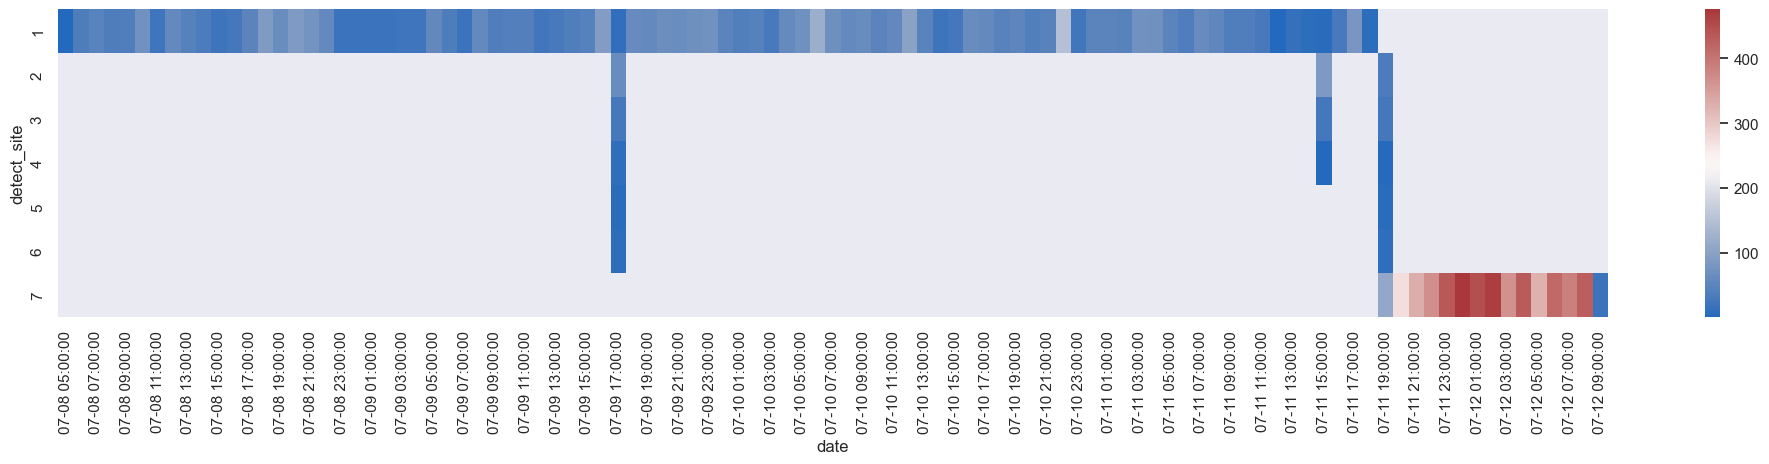

In [60]:
f, ax = plt.subplots(figsize=(25, 4))

# g = sns.heatmap(plot_detections, annot=False, linewidths=.5, ax=ax)
g = sns.heatmap(plot_detections, annot=False, ax=ax, cmap="vlag")



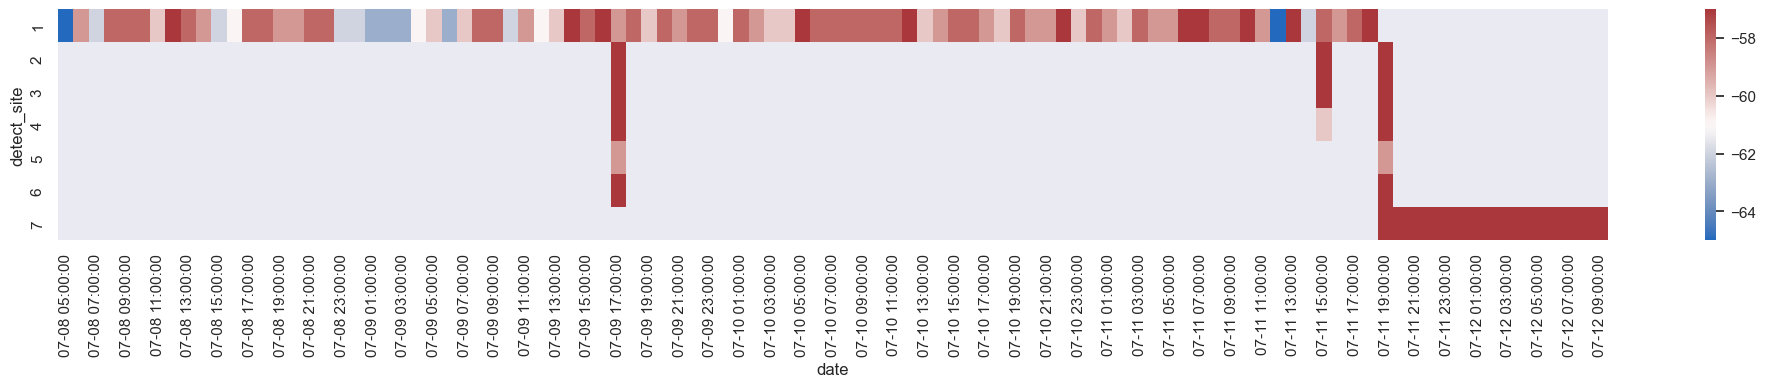

In [61]:
f, ax = plt.subplots(figsize=(25, 3))

g = sns.heatmap(plot_power, annot=False, cmap="vlag", ax=ax)


## format events for use in travel time

In [62]:
%%time

# dictionary of detetion sites to travel time file abbreviation
detect_site_to_abbrev_dict = {1: "sw",
                              2: "e1",
                              3: "e2",
                              4: "l1",
                              5: "l2",
                              6: "l3",
                              7: "ps"}


# generate last event time for each detection site
events_nops_last = events_nops.groupby(["fish_id", "grouping", "detect_site"])["date_time"].max().reset_index()
events_nops_last["site_abbrev"] = events_nops_last["detect_site"].map(detect_site_to_abbrev_dict).str.lower() + "_l"

# generate first event time for each detection site
events_nops_first = events_nops.groupby(["fish_id", "grouping", "detect_site"])["date_time"].min().reset_index()
events_nops_first["site_abbrev"] = events_nops_first["detect_site"].map(detect_site_to_abbrev_dict).str.lower() + "_f"

# combine
events_nops_tt = pd.concat([events_nops_first, events_nops_last])

events_nops_tt.shape


CPU times: total: 0 ns
Wall time: 13 ms


(14, 5)

In [63]:
events_nops_tt.sort_values(by="detect_site")

,fish_id,grouping,detect_site,date_time,site_abbrev
6,166.620.103,3_60,1,2022-07-08 05:58:47,sw_f
6,166.620.103,3_60,1,2022-07-11 18:44:15,sw_l
0,166.620.103,2_120,2,2022-07-09 17:14:17,e1_f
0,166.620.103,2_120,2,2022-07-11 19:11:34,e1_l
1,166.620.103,2_120,3,2022-07-09 17:18:02,e2_f
1,166.620.103,2_120,3,2022-07-11 19:16:03,e2_l
2,166.620.103,2_120,4,2022-07-09 17:24:22,l1_f
2,166.620.103,2_120,4,2022-07-11 19:17:37,l1_l
3,166.620.103,2_120,5,2022-07-09 17:32:32,l2_f
3,166.620.103,2_120,5,2022-07-11 19:24:01,l2_l


# The following is in-development

## generate travel time with no ops

In [67]:
# dictionary of data types for the travel time data frame
travel_time_template_dtypes = {
    # "fish_id": str,
    "pit_code": str,
    "rel_name": str,
    "lot": int,
    "srr": str,
    "act_datetime": "datetime64[ns]",
    "release_datetime": "datetime64[ns]",
    "hole": str,
    "subhole": str,
    "sw": int,
    "e1": int,
    "e2": int,
    "l1": int,
    "l2": int,
    "l3": int,
    "ps": int,
    "sw_f": "datetime64[ns]",
    "sw_l": "datetime64[ns]",
    "e1_f": "datetime64[ns]",
    "e1_l": "datetime64[ns]",
    "e2_f": "datetime64[ns]",
    "e2_l": "datetime64[ns]",
    "l1_f": "datetime64[ns]",
    "l1_l": "datetime64[ns]",
    "l2_f": "datetime64[ns]",
    "l2_l": "datetime64[ns]",
    "l3_f": "datetime64[ns]",
    "l3_l": "datetime64[ns]",
    "ps_f": "datetime64[ns]",
    "ps_l": "datetime64[ns]",
    "rel_weir_time_s": int,
    "pool_stage": str,
    "censor": int,
    "altered": int,
    "mort_xlat": int,
    "release_stage": str,
    "comments": str
}

# build a dictionary of field with empty data
travel_time_template_dict = {i: [] for i in travel_time_template_dtypes.keys()}

# generate travel time template
travel_time_template = pd.DataFrame(travel_time_template_dict).astype(travel_time_template_dtypes)

# add fish ids to the travel time file
travel_time_template["fish_id"] = tagging_df.index

# set template site designation to 0 
detection_site_abbrev_list = ["sw", "e1", "e2", "l1", "l2", "l3", "ps"]
travel_time_template[detection_site_abbrev_list] = 0

# generate a list of detection site first and last columns in order
detection_site_time_columns = []
for i in detection_site_abbrev_list:
    detection_site_time_columns.append(f"{i}_f")
    detection_site_time_columns.append(f"{i}_l")

# sort by fish id
travel_time_template.sort_values(by=["fish_id"], inplace=True)

# set index to fish id
travel_time_template.set_index("fish_id", inplace=True)


In [68]:
events_nops_tt_layout = pd.pivot_table(events_nops_tt,
                                       values="date_time",
                                       index=["fish_id"],
                                       columns=["site_abbrev"]).rename_axis(None, axis=1)

# add empty columns to make full travel time input
events_nops_tt_layout_columns = events_nops_tt_layout.columns

for i in travel_time_template_dtypes.keys():
    
    if i not in events_nops_tt_layout_columns:
        events_nops_tt_layout[i] = None

# reorder columns
events_nops_tt_layout = events_nops_tt_layout[travel_time_template_dtypes.keys()]

events_nops_tt_layout.to_csv("/Users/d3y010/Desktop/template_no-ops.csv", index=True)

    

In [70]:
events_ops = events_nops.copy()

In [71]:
# update template fields for each detection site where an event was logged regardless of whether or not the fish passed the site
x = events_ops.set_index("fish_id")["detect_site"].map({i: detect_site_to_abbrev_dict[i].lower() for i in detect_site_to_abbrev_dict.keys()}).reset_index()

x["detected"] = 1

detect_designation = pd.pivot_table(x, values="detected", index="fish_id", columns="detect_site", fill_value=0).rename_axis(None, axis=1)

# update the template data frame with the new data
travel_time_template.update(detect_designation)


In [72]:
# build release name needed in travel time file
tagging_df["rel_name"] = tagging_df["release_location_xlat"] + "_" + tagging_df["srr"]

# extract that tagging file information needed for the travel time data frame
tagging_for_tt = tagging_df[["pit_code", "rel_name", "srr", "tag_activation_date_pst", "tag_release_date_pst", "mort_xlat"]].copy()

# rename columns to what is expected in the travel time data frame
tagging_for_tt.rename(columns={"tag_activation_date_pst": "act_datetime", 
                               "tag_release_date_pst": "release_datetime"},
                      inplace=True)

# update the template data frame with the new data
travel_time_template.update(tagging_for_tt)


In [73]:
travel_time_template

,pit_code,rel_name,lot,srr,act_datetime,release_datetime,hole,subhole,sw,e1,...,l3_l,ps_f,ps_l,rel_weir_time_s,pool_stage,censor,altered,mort_xlat,release_stage,comments
fish_id,,,,,,,,,,,,,,,,,,,,,
0,3DD.003BD5543A,R1_stuck_11W,NaN,11W,2022-06-21 16:16:01,2022-06-22 12:32:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,3DD.003BD55446,R1_stuck_11W,NaN,11W,2022-06-21 16:13:55,2022-06-22 12:32:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,3DD.003BD55460,R1_stuck_11W,NaN,11W,2022-06-21 16:15:49,2022-06-22 12:32:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,3DD.003BD5544C,R2_fpf_11W,NaN,11W,2022-06-21 16:28:37,2022-06-26 08:30:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,3DD.003BD55440,R1_stuck_11W,NaN,11W,2022-06-21 16:26:59,2022-06-24 11:02:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,3DD.003BD55461,R3_stewart_11W,NaN,11W,2022-06-24 15:44:37,2022-06-27 14:20:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN
71,3DD.003BD5541D,R3_stewart_11W,NaN,11W,2022-06-24 15:46:29,2022-06-27 14:20:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN
72,3DD.003BD5543F,R3_stewart_11W,NaN,11W,2022-06-27 19:06:38,2022-06-28 11:52:00,NaN,NaN,0,0,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.0,NaN,NaN


**NOTE**: apply pool and release stage

### route of passage

In [57]:
hole_dict = {4: "SW4",
             5: "SP2",
             6: "SP3",
             7: "SP4",
             9: "PS2",
             10: "PS1"}

subhole_dict = {4: "WEIR",
                5: "NON-WEIR",
                6: "NON-WEIR",
                7: "NON-WEIR",
                9: "TURBINE",
                10: "TURBINE"}


In [58]:
# for fish with a dam last with or without a downstream event
dam_last_tt_fish = travel_time_template[["dam_l"]].loc[~travel_time_template[["dam_l"]]["dam_l"].isna()]

route_dam_last = events_ops.loc[(events_ops["fish_id"].isin(dam_last_tt_fish.index)) & 
                                (events_ops["date_time"].isin(dam_last_tt_fish["dam_l"])) &
                                (events_ops["detect_site"] == dam_detect_site)].sort_values(by=["fish_id"]).reset_index(drop=True)[["fish_id", "site_number"]].copy()

# add hole
route_dam_last["hole"] = route_dam_last["site_number"].map(hole_dict)

# add subhole
route_dam_last["subhole"] = route_dam_last["site_number"].map(subhole_dict)

# # drop site number
# route_dam_last.drop(columns=["site_number"], inplace=True)

route_dam_last.set_index("fish_id", inplace=True)

route_dam_hole_dict = route_dam_last["hole"].to_dict()
route_dam_subhole_dict = route_dam_last["subhole"].to_dict()

travel_time_template_hole = travel_time_template["hole"].to_dict()
travel_time_template_hole.update(route_dam_hole_dict)
travel_time_template["hole"] = travel_time_template.index.map(travel_time_template_hole)


travel_time_template_subhole = travel_time_template["subhole"].to_dict()
travel_time_template_subhole.update(route_dam_subhole_dict)
travel_time_template["subhole"] = travel_time_template.index.map(travel_time_template_subhole)


In [59]:
# for fish with no dam last but a downstream event
forebay_downstream_sites = ['dam', 'tw', 'egr', 'prm', 'leb', 'srs', 'coi', 'wil']

route_fby_only = travel_time_template.loc[travel_time_template["fby"] == 1][forebay_downstream_sites].copy()

route_fby_only["hole"] = np.where(route_fby_only[forebay_downstream_sites].sum(axis=1) == 0, "FBY", "NA")

route_fby_only = route_fby_only.loc[route_fby_only["hole"] == "FBY"]

route_fby_only["subhole"] = "NaN"

route_fby_only.drop(columns=['dam', 'tw', 'egr', 'prm', 'leb', 'srs', 'coi', 'wil'], inplace=True)

travel_time_template.update(route_fby_only)

route_fby_only.shape


(25, 2)

In [60]:
# travel_time_template['gp_fby_f'] = pd.to_datetime(travel_time_template['gp_fby_f'])
# travel_time_template['gp_fby_l'] = pd.to_datetime(travel_time_template['gp_fby_l'])
# travel_time_template['gp_tw_f'] = pd.to_datetime(travel_time_template['gp_tw_f'])
# travel_time_template['gp_tw_l'] = pd.to_datetime(travel_time_template['gp_tw_l'])
# travel_time_template['sun_f'] = pd.to_datetime(travel_time_template['sun_f'])
# travel_time_template['sun_l'] = pd.to_datetime(travel_time_template['sun_l'])
# travel_time_template['fby_f'] = pd.to_datetime(travel_time_template['fby_f'])
# travel_time_template['fby_l'] = pd.to_datetime(travel_time_template['fby_l'])
# travel_time_template['bc_f'] = pd.to_datetime(travel_time_template['bc_f'])
# travel_time_template['bc_l'] = pd.to_datetime(travel_time_template['bc_l'])
# travel_time_template['dam_f'] = pd.to_datetime(travel_time_template['dam_f'])
# travel_time_template['dam_l'] = pd.to_datetime(travel_time_template['dam_l'])
# travel_time_template['tw_f'] = pd.to_datetime(travel_time_template['tw_f'])
# travel_time_template['tw_l'] = pd.to_datetime(travel_time_template['tw_l'])
# travel_time_template['egr_f'] = pd.to_datetime(travel_time_template['egr_f'])
# travel_time_template['egr_l'] = pd.to_datetime(travel_time_template['egr_l'])
# travel_time_template['prm_f'] = pd.to_datetime(travel_time_template['prm_f'])
# travel_time_template['prm_l'] = pd.to_datetime(travel_time_template['prm_l'])
# travel_time_template['leb_f'] = pd.to_datetime(travel_time_template['leb_f'])
# travel_time_template['leb_l'] = pd.to_datetime(travel_time_template['leb_l'])
# travel_time_template['srs_f'] = pd.to_datetime(travel_time_template['srs_f'])
# travel_time_template['srs_l'] = pd.to_datetime(travel_time_template['srs_l'])
# travel_time_template['coi_f'] = pd.to_datetime(travel_time_template['coi_f'])
# travel_time_template['coi_l'] = pd.to_datetime(travel_time_template['coi_l'])
# travel_time_template['wil_f'] = pd.to_datetime(travel_time_template['wil_f'])
# travel_time_template['wil_l'] = pd.to_datetime(travel_time_template['wil_l'])


# travel_time_template.to_csv("/Users/d3y010/Desktop/template_ops.csv", index=True)


- are we setting bc last to dam last?
    - pupose of BC arrays (underwater antennas) was to use them to produce a route of passage if there was none (not so much to define the timestamp)
    - bc last is always dam last when dam last exists
    - Options:  1) remove BC arrays from travel time file, 2) or keep them;
    
- fby last is always dam last if exists
- can fby first be > then fby l? or bc"
- for predation: do you want me to screen the FBY detections after downstream? from event validation?  [YES]
- what does 1, 0 actually mean for sites?  is it passage or just detection?  Should these be based off of events with no ops considered?
    - 1 means detected at every site but dam; where 1 means passed at dam and bc (should use dam considering operations)
    - this works because there is no barrier at the other sites
- no seconds in most of the tt revisions
    - on me
- is there a policy on removing detections for dam only events with no upstream or downstream events? some inconsistency here; see FBY == 0 and DAM == 1
- explore condition for daylight savings time
- 
